# Graph-based dimensionality reduction

---

### _Zichen Wang, PhD_
### Ma'ayan lab meeting
### Jun. 16, 2017

---

## 1. Introduction
### 1.1. Dimensionality reduction (DR)

+ #### Motivation    
    Many real-world data are high-dimentional, that is, having many features: images, videos, natural languages, biological/biomedial data: gene expression, EMR and etc. 
    Reduce the dimentionality of data to:
    - **Visualization**: from $m$ to 2 or 3, can help us plot the data points, thus enabling visualization.
    - **Model/Machine Learning**: from $m$ to $d$ where $d << m$. Data may lie into a lower-dimensional manifold. The low-dimensional representation of the data is easier to model.
    

+ #### Defination/Formulation 
    We have $n \times m$ data matrix $\mathbf{X}$ consisting of $n$ data vectors $\mathbf{x_i} (i ∈ {1, 2,. .. ,n})$ with dimensionality $m$. The goal of DR is to map $\mathbf{X}$ to a $n \times d$ matrix $\mathbf{X'}$ where $d << m$.
+ #### Principal Components Analysis (PCA)
    Find linearly uncorrelated orthogonal axes (principal components, PC) in the $m$ dimensional space to project the data points onto those PCs. The first several PCs capture the largest variance in the data.
    ![](https://i.stack.imgur.com/lNHqt.gif)    
+ #### Types
    - Linear: PCA
    - [Non-linear](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)
        + **Distance-based embedding**: Preserve the distances between data points in high-dimensional space. Many, if not all, involves the use of a graph to represent the distances. 
            - Examples algorithms: [t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), Spectral Embedding. 
            - Non-parametric: cannot fit new data points in high-dimensional space into the embedding space.
        + **Parametric**: Learn a function that maps data from high-dimentional space to low-dimentional space: [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder)    


### 1.2. Graph theory

+ $G(V, E)$: a set of vertices/nodes $V$ connected by a set of edges $E$. Edges in the graph can be directed or undirected.
![Undirected graph](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/500px-6n-graf.svg.png)

+ Important concepts:
    - **Degree**: number of edges for a given node
    - **Degree distribution**: probability distribution of degree of nodes.    
    power-law degree distribution:
    ![power-law degree distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Barabasi-albert_model_degree_distribution.svg/731px-Barabasi-albert_model_degree_distribution.svg.png)
    Random network and scale-free network:
    ![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Scale-free_network_sample.png/800px-Scale-free_network_sample.png)
    - **Adjacency matrix**: $$
    \mathbf{A} = [A_{ij}] = 
    \begin{cases}
      0, & \text{if node i, j are not connected}\  \\
      w_{ij}, & \text{otherwise}
    \end{cases}
    $$
    - **Laplacian matrix**: $$
    \mathbf{L} = \mathbf{D} - \mathbf{A}
    $$
+ Network layout algorithms:
    - **Force-based layout**: repulsive forces between all pairs of nodes, attractive forces on edges. https://bl.ocks.org/mbostock/4062045


---

## 2. Graph-based dimensionality reduction

### Workflow:

$\mathbf{X}$ ($n$ by $m$) -> compute pairwise distance/similarity matrix -> $mathbf{A}$ ($n$ by $n$) -> form a graph $G$ to represent the local and global geometric/topological structures of the data -> project into low-dimensional space.

- **Spectral Embedding**: also known as Laplacian Eigenmaps. Performs PCA on the Laplacian matrix.
- **t-SNE**: t-distributed stochastic neighbor embedding. 
    0. Converts pairwise distances between data points to probability distribution such that closer data points have higher probability of being picked together
    0. Make a similar probability distribution in the low-dimentional space and minimize the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions.

- **Firework Layout**: uses force-based layout algorithm (edge-repulsive strong clustering) to project the similarity graph into 2D space. This has been used to visualize [gene expression signatures](http://amp.pharm.mssm.edu/L1000FWD/), and [patients in EMR](http://amp.pharm.mssm.edu/emr-net1/). 
    How to to convert $\mathbf{A}$ to $G$?
    + k-Nearest Neighbor (kNN) graph: how to choose k?
    + Thresholding: how to choose a threshold?
    + b-matching?


---

## 3. Experiments on MNIST data

- MNIST: 28x28 pixel images in grey scale of handwritten digits
- Evaluate different DR algorithms by
    0. Visual inspection
    0. Generalization errors: calculate the generalization errors of 1-nearest neighbor classifiers that are trained on the low-dimensional data representation. As is done in [van der Maaten et al. Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf).
        - Intuition: do the nearest pairs of points in the same class?


---


## 4. [References](#refs)

In [1]:
from __future__ import division
import os
import sys
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import networkx as nx
from sklearn import preprocessing, manifold, decomposition, neighbors
from sklearn.model_selection import cross_val_score

from tensorflow.examples.tutorials.mnist import input_data

import requests

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from IPython import display

sys.path.append('/Users/zichen/Documents/bitbucket/maayanlab_utils/')
from plots import COLORS10

np.random.seed(2017)

Retrieve the MNIST data and sample a subset to experiment on.

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print mnist.train.num_examples
print mnist.test.num_examples

55000
10000


In [4]:
N = 2000 # number of samples
X, labels = mnist.train.next_batch(N)
print X.shape, labels.shape

(2000, 784) (2000,)


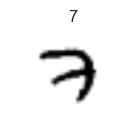

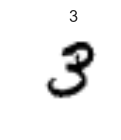

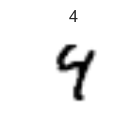

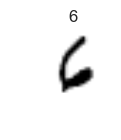

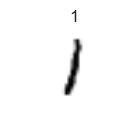

In [6]:
for i in range(5):
    plt.figure(figsize=(1,1))
    plt.imshow(X[i].reshape(28, 28))
    plt.axis('off')
    plt.title(labels[i])

#### Perform PCA on the data

(2000, 784)
Explained variance ratio by PCs: [ 0.11102765  0.07442068  0.06541306  0.05872714  0.04769295  0.04443822
  0.0326397   0.0293337   0.02737937  0.02434547  0.02096938  0.02007064
  0.01751817  0.01684177  0.01589352  0.01460138  0.01276829  0.01208974
  0.01166841  0.01072288]


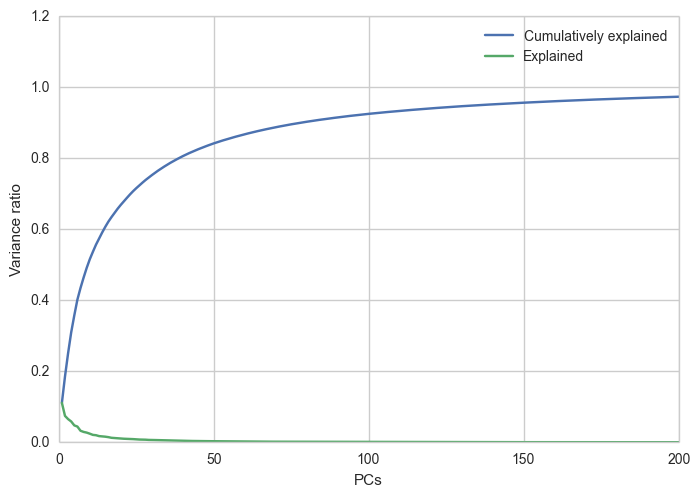

In [7]:
pca = decomposition.PCA()
X_pca = pca.fit_transform(X)
print X_pca.shape
print 'Explained variance ratio by PCs:', pca.explained_variance_ratio_[:20]
cum_var_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(len(cum_var_explained))+1, cum_var_explained, label='Cumulatively explained')
plt.plot(np.arange(len(cum_var_explained))+1, pca.explained_variance_ratio_, label='Explained')
plt.legend(loc='best')
plt.xlim([0, 200])
plt.xlabel('PCs')
plt.ylabel('Variance ratio')

In [8]:
def plot_embed(X_coords, labels):
    '''Scatter plot for the coordinates colored by their labels'''
    X_coords = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_coords[:, :2])

    fig, ax = plt.subplots(figsize=(5,5))
    scatter_proxies = []
    colors = [COLORS10[l] for l in labels]
    ax.scatter(X_coords[:, 0], X_coords[:, 1], s=5, c=colors, edgecolor='none')
    for i in range(10):
        scatter_proxy = Line2D([0],[0], ls="none", 
                               c=COLORS10[i], 
                               marker='o', 
                               markersize=5, 
                               markeredgecolor='none')    
        scatter_proxies.append(scatter_proxy)

    ax.legend(scatter_proxies, map(str, range(10)), numpoints=1, frameon=False, loc='best')
    fig.tight_layout()
    return ax


Evaluate using the generalization errors of 1-nearest neighbor classifiers that are trained on the low-dimensional data representation. As is done in [van der Maaten et al. Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf)


In [9]:
# Split data points into 80% training and 20% testing
def NN_generalization_error(X, labels):
    '''Train 1-NN classifier on the training set of the low-dim data,
    and evaluate on the test set to get the error (1-accuracy).
    '''
    clf = neighbors.KNeighborsClassifier(n_neighbors=1)
    # 5-fold cross-validation averaged accuracy
    avg_accuracy = cross_val_score(clf, X[:, :2], labels, cv=5).mean()
    error = 1 - avg_accuracy
    return error

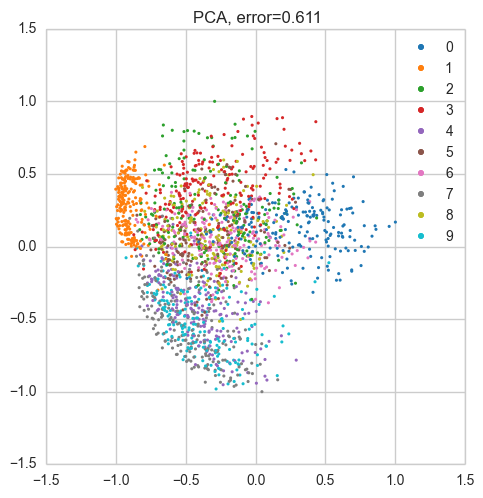

In [10]:
ax = plot_embed(X_pca, labels)
error = NN_generalization_error(X_pca, labels)
ax.set_title('PCA, error=%.3f' % error)

#### Perform Spectral Embedding using different _k_ to construct kNN graph

Spectral Embedding: 
0. Compute the pairwise distance matrix
0. Construct a kNN graph based on the pairwise distance matrix
0. Perform PCA on the Laplacian matrix of the kNN graph

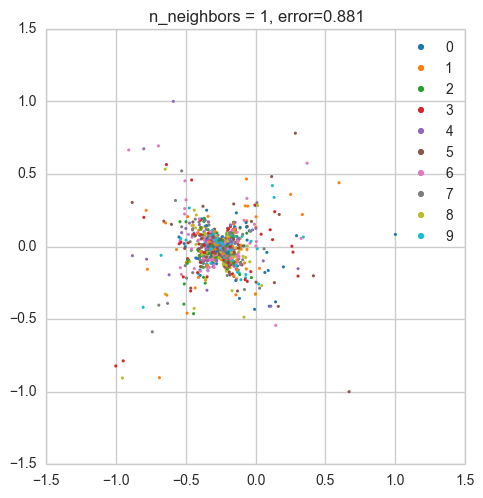

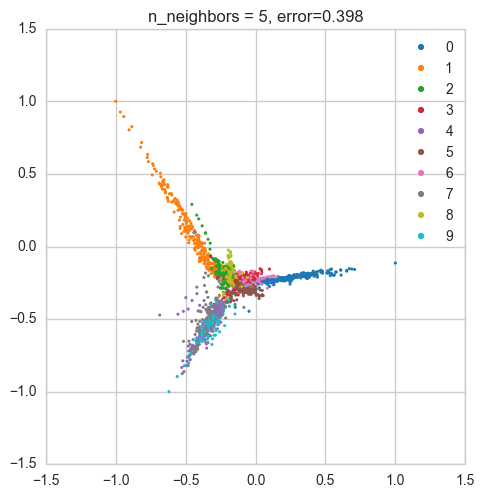

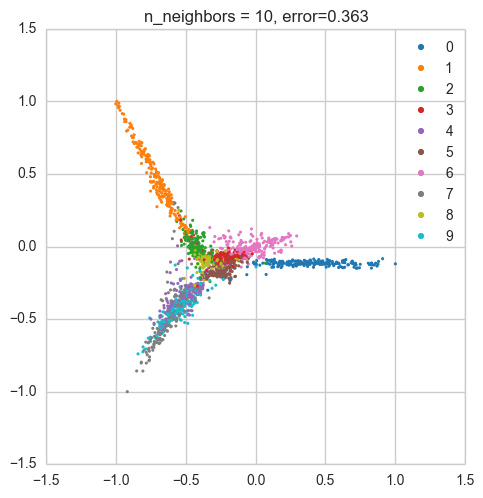

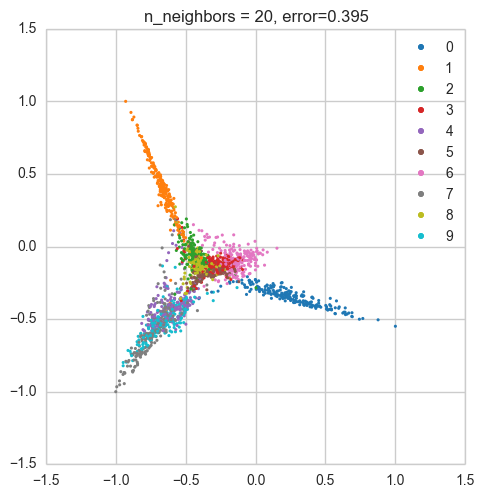

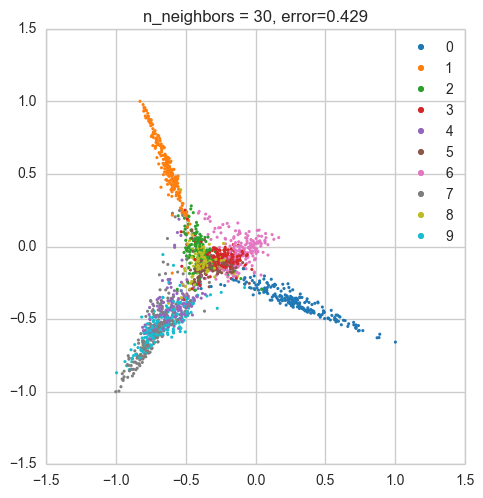

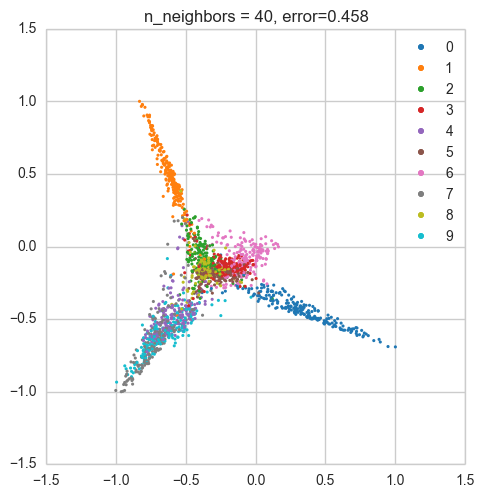

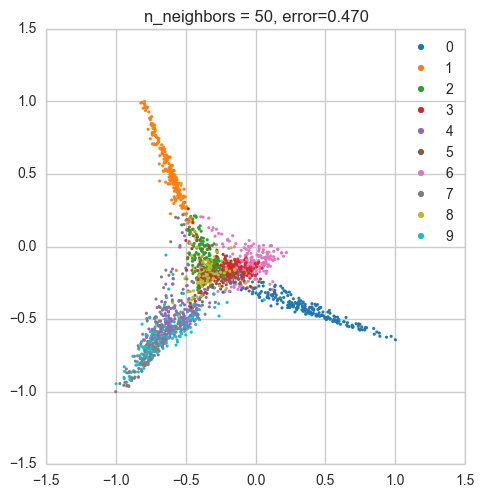

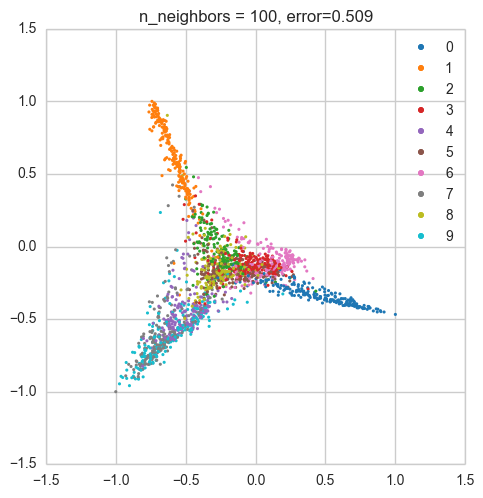

In [11]:
for n_neighbors in [1, 5, 10, 20, 30, 40, 50, 100]:
    se = manifold.SpectralEmbedding(affinity='nearest_neighbors', n_neighbors=n_neighbors)
    X_se = se.fit_transform(X_pca[:, :50])
    ax = plot_embed(X_se, labels)
    error = NN_generalization_error(X_se, labels)
    ax.set_title('n_neighbors = %d, error=%.3f' % (n_neighbors, error))

#### Perform t-SNE

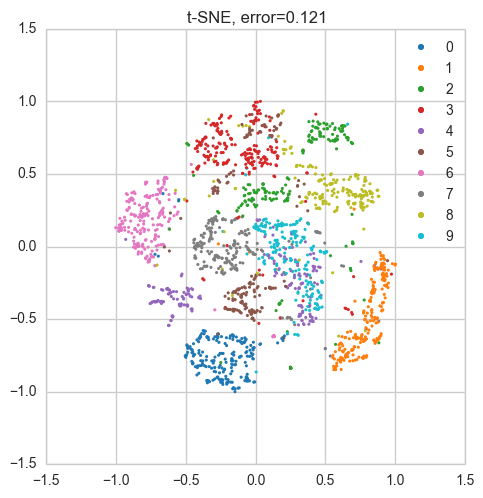

In [12]:
tsne = manifold.TSNE(metric='euclidean')

X_tsne = tsne.fit_transform(X_pca[:, :50])
# X_tsne = tsne.fit_transform(X)
ax = plot_embed(X_tsne, labels)
error = NN_generalization_error(X_tsne, labels)
ax.set_title('t-SNE, error=%.3f' % error)

### DR by the firework network layout

**How to convert the pairwise distance/similarity matrix to a graph?** 

- kNN graph
- Thresholding

#### Uses kNN graph for the layout 

In [13]:
from collections import Counter, OrderedDict
from sklearn.metrics.pairwise import pairwise_distances

# modules to interact with CyREST, the API of Cytoscape
from py2cytoscape.data.cyrest_client import CyRestClient
import py2cytoscape.cytoscapejs as renderer

<IPython.core.display.Javascript object>

In [14]:
def compute_adjcency_mat(X, metric='euclidean'):
    pdist = pairwise_distances(X, metric=metric)
    adj_mat = 1 - pdist / pdist.max()
    # remove 1's on the diagnal
    adj_mat -= np.eye(X.shape[0])
    return adj_mat

def plot_degree_distribution(G):
    """G: a nx.Graph object
    """
    fig, ax = plt.subplots(figsize=(5,5))
    
    degrees = G.degree().values()
    degrees = dict(Counter(degrees))
    x = degrees.keys()
    y = degrees.values()

    ax.scatter(x, y, s=10, alpha=.6)
    ax.set_xlabel('Degree', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)    
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.tight_layout()
    return ax
    
def create_knn_graph(X, k=30, metric='euclidean'):
    '''Create a graph from a data matrix (sample x features).
    '''
    adj_mat = neighbors.kneighbors_graph(X, k, mode='connectivity', metric=metric)
    G = nx.from_scipy_sparse_matrix(adj_mat)
    return G

2000 2000


/Library/Python/2.7/site-packages/sklearn/neighbors/graph.py:37: DeprecationWarning: The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.
  "behavior, set include_self=True.", DeprecationWarning)


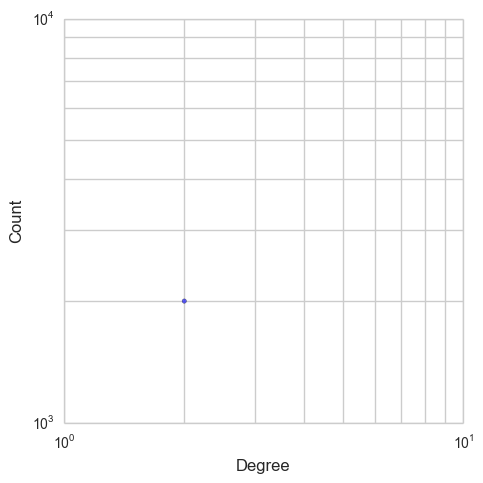

In [53]:
# G = create_knn_graph(X_pca[:, :50], k=30)
G = create_knn_graph(X_pca[:, :50], k=1)
print G.number_of_nodes(), G.number_of_edges()
plot_degree_distribution(G)

In [38]:
# G[0][0]
edge_betweeness = nx.edge_betweenness_centrality(G, weight='weight')

In [39]:
print G.number_of_nodes(), G.number_of_edges()
print len(edge_betweeness)

2000 7701
7701


In [40]:
print max(edge_betweeness.values()), min(edge_betweeness.values())

0.0202313295047 0.0


0.000453885282514
0.000642077491029
0.000931779258266
0.0014055489459
0.00247304835351
0.00388445526945


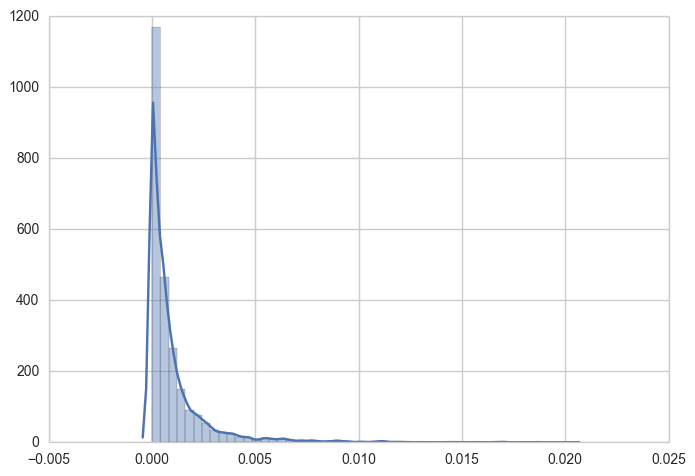

In [41]:
all_edge_betweeness_values = edge_betweeness.values()

for percentile in [50, 60, 70, 80, 90, 95]:
    print np.percentile(all_edge_betweeness_values, percentile)

sns.distplot(all_edge_betweeness_values)

In [48]:
edges_to_remove = [e for e, val in edge_betweeness.items() if val < 4.5e-4]
G.remove_edges_from(edges_to_remove)
print G.number_of_nodes(), G.number_of_edges()

2000 3868


In [49]:
# Params for CyREST
IP = '127.0.0.1'
PORT = 1234
BASE_URL = 'http://%s:%s/v1' % (IP, PORT)
HEADERS = {'Content-Type': 'application/json'}

def network_layout(G):
    '''POST the network to CyREST, then run layout algorithm, 
    finally return the coordinates and the cy_network.
    '''
    # Create Py2cytoscape client
    cy = CyRestClient(ip=IP, port=PORT)
    # Reset session
    cy.session.delete()
    # POST the graph to CyREST
    G_cy = cy.network.create_from_networkx(G)

    # Change the layout params
    layout_parameters = [
        {"name": "numIterations", "value": 10}, 
        {"name":"numIterationsEdgeRepulsive", "value":10}
    ]
    resp = requests.put(BASE_URL+ '/apply/layouts/force-directed-cl/parameters', 
                 data=json.dumps(layout_parameters),
                 headers=HEADERS)
    cy.layout.apply(name='force-directed-cl', network=G_cy)


    layout_parameters = [
        {"name": "maxIterations", "value": 10000}, 
        {"name":"randomize", "value":True},
    ]
    resp = requests.put(BASE_URL+ '/apply/layouts/allegro-edge-repulsive-strong-clustering/parameters', 
                 data=json.dumps(layout_parameters),
                 headers=HEADERS)
    cy.layout.apply(name='allegro-edge-repulsive-strong-clustering', network=G_cy)
    # Get current view
    view = G_cy.get_first_view()
    nodes = view['elements']['nodes']
    # Get a coord matrix ordered by id_original
    ids_original = np.array([n['data']['id_original'] for n in nodes]).astype(np.int32)
    xs = [n['position']['x'] for n in nodes]
    ys = [n['position']['y'] for n in nodes]
    coords = np.array([xs, ys]).T
    return coords[ids_original], G_cy
    

In [50]:
X_knn_fw, G_cy = network_layout(G)
print X_knn_fw.shape

(2000, 2)


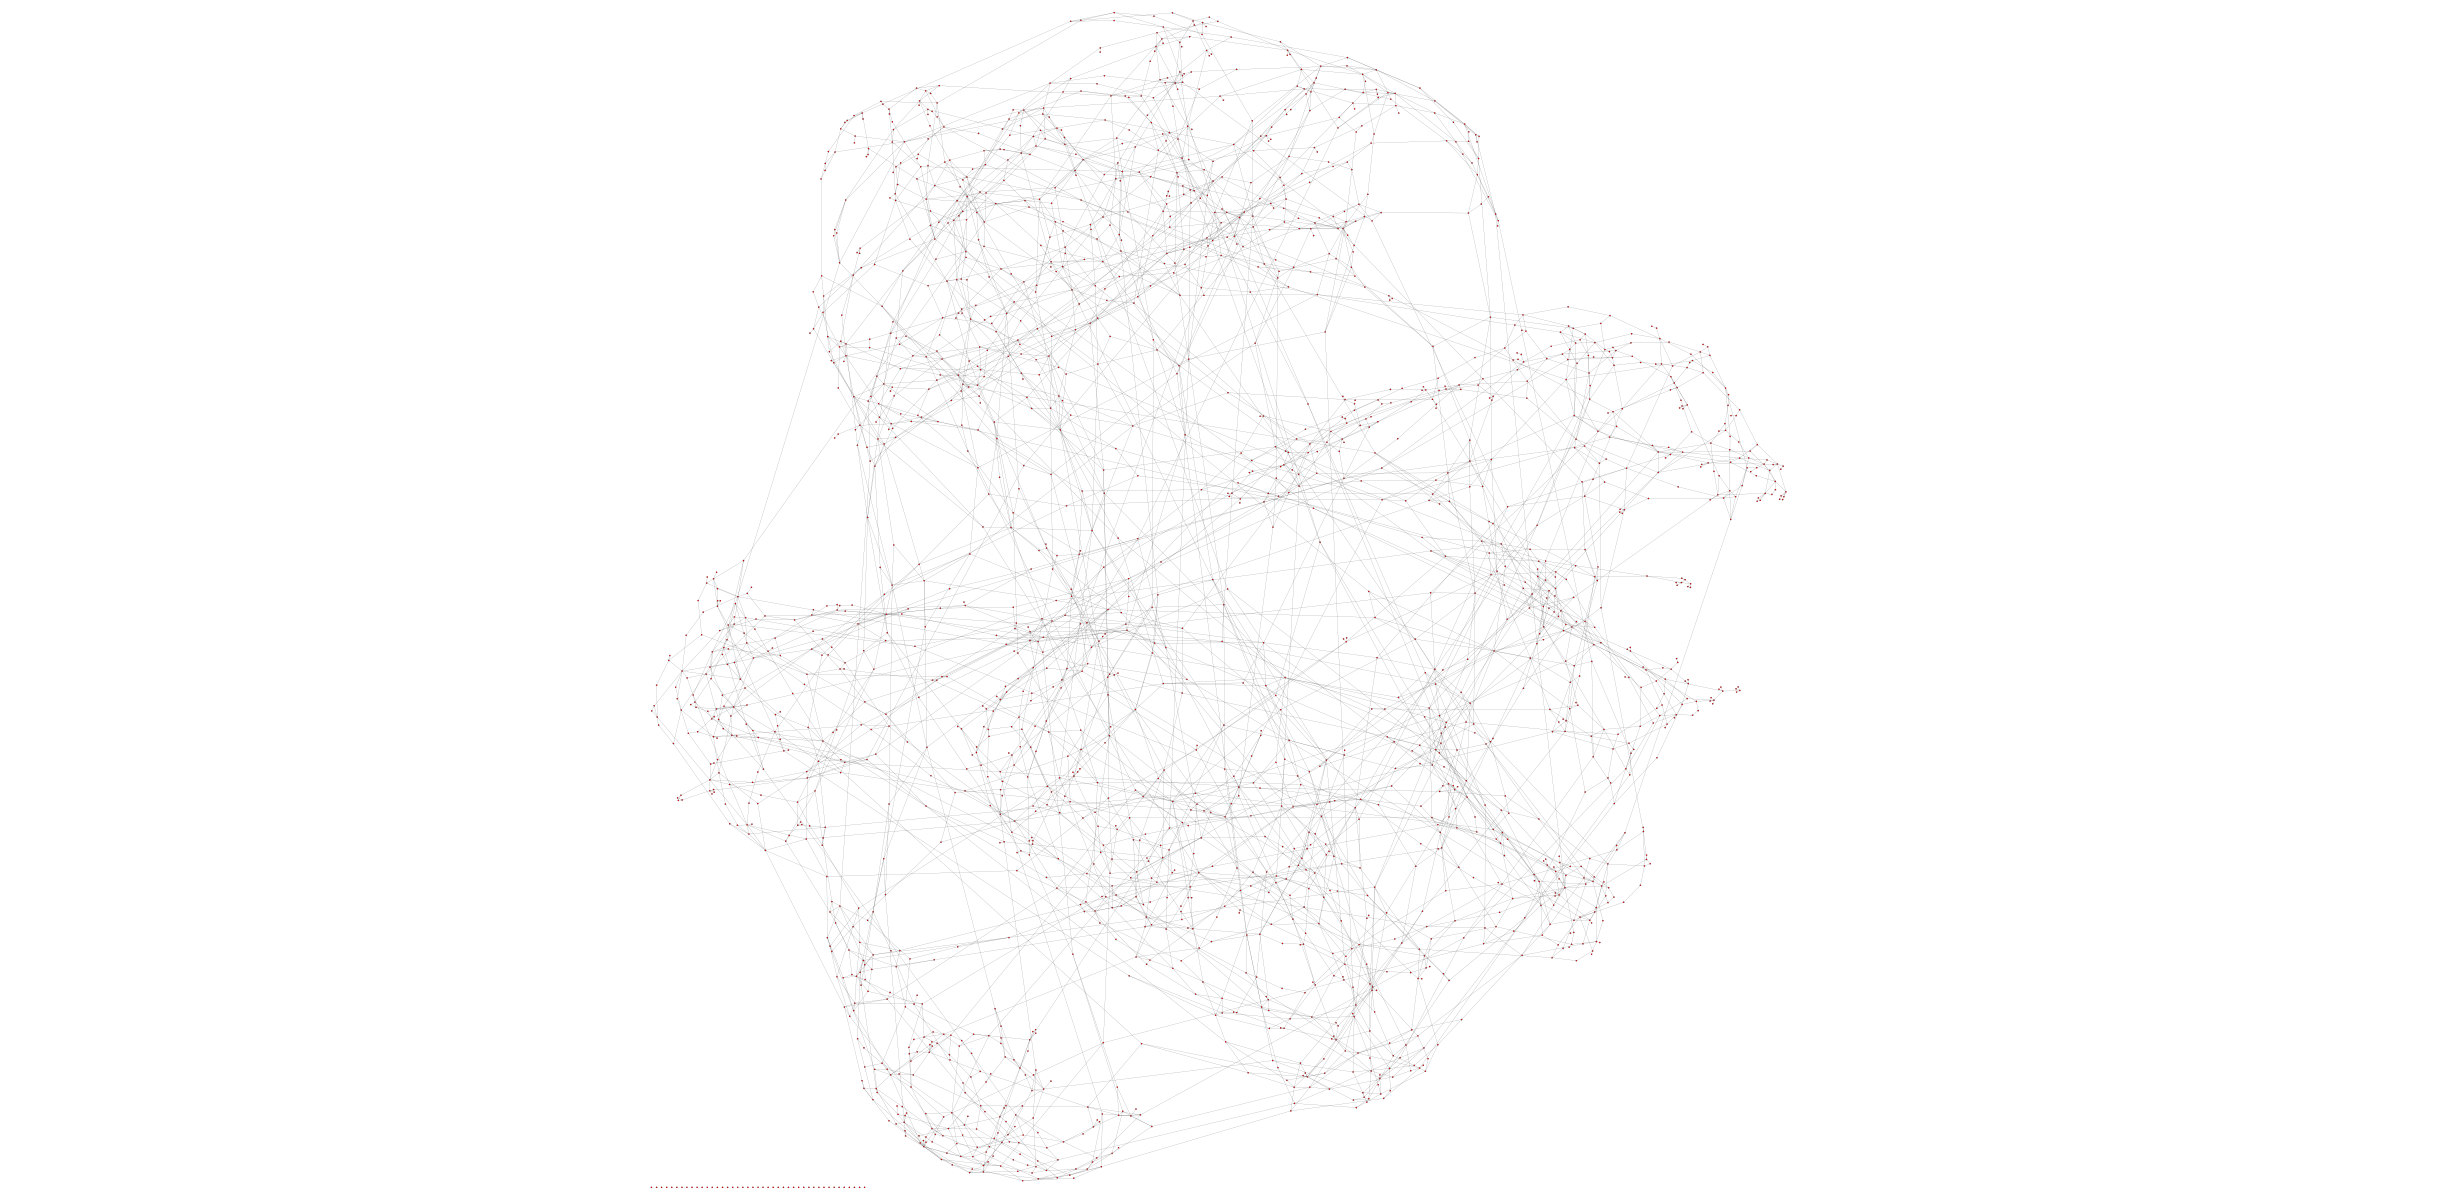

In [51]:
# Display the current layout from Cytoscape
display.Image(G_cy.get_png())

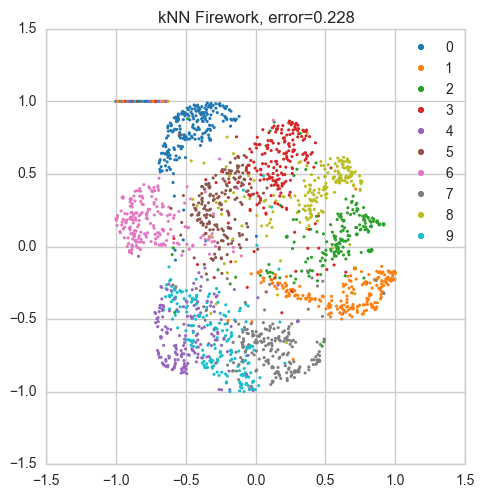

In [52]:
error = NN_generalization_error(X_knn_fw, labels)
ax = plot_embed(X_knn_fw, labels)
ax.set_title('kNN Firework, error=%.3f' % error)

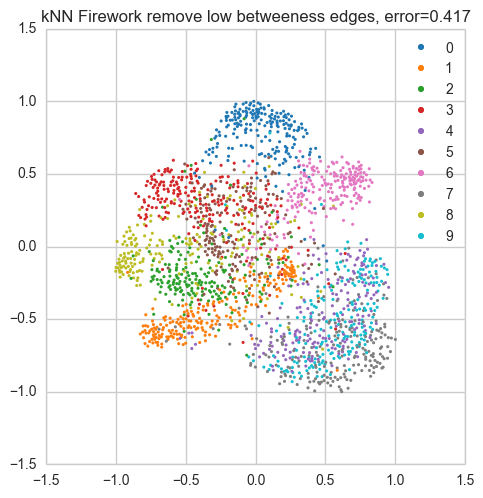

In [33]:
error = NN_generalization_error(X_knn_fw, labels)
ax = plot_embed(X_knn_fw, labels)
ax.set_title('kNN Firework remove low betweeness edges, error=%.3f' % error)

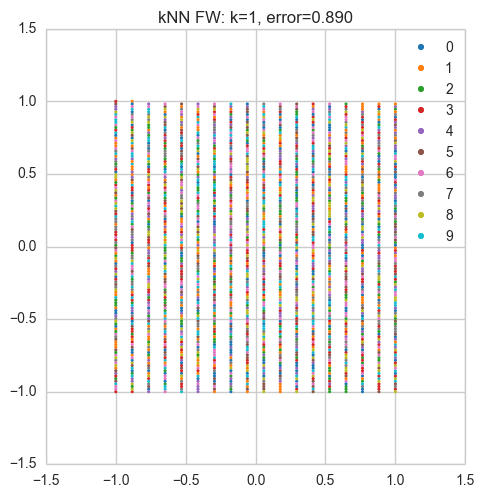

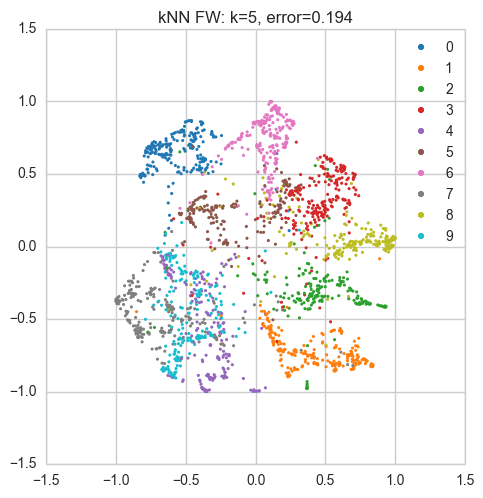

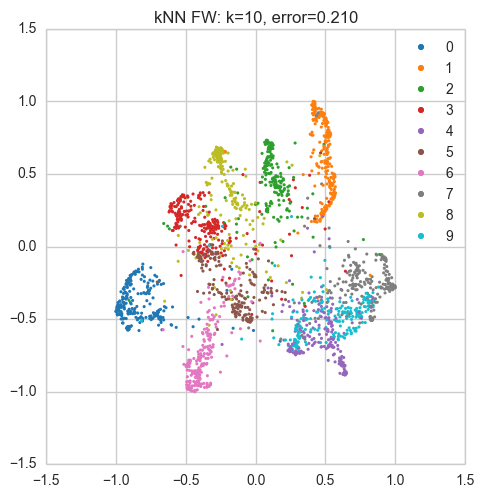

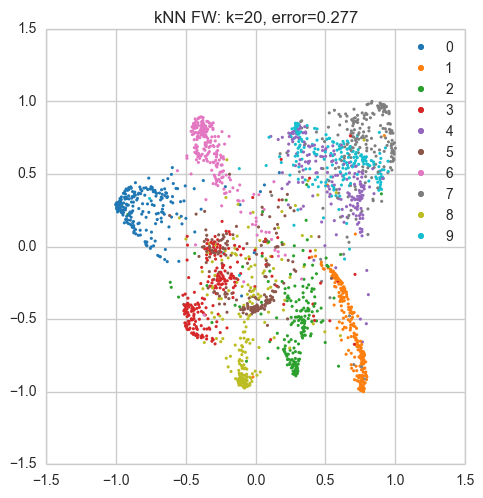

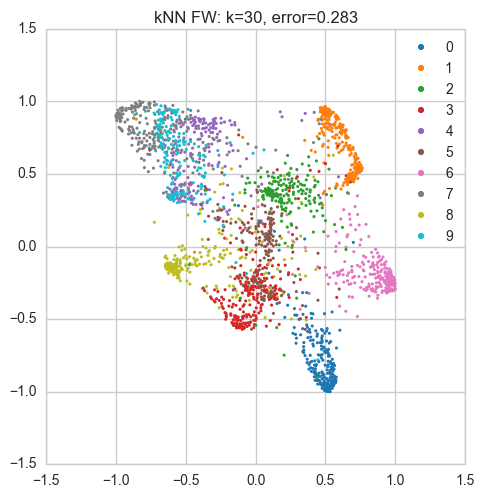

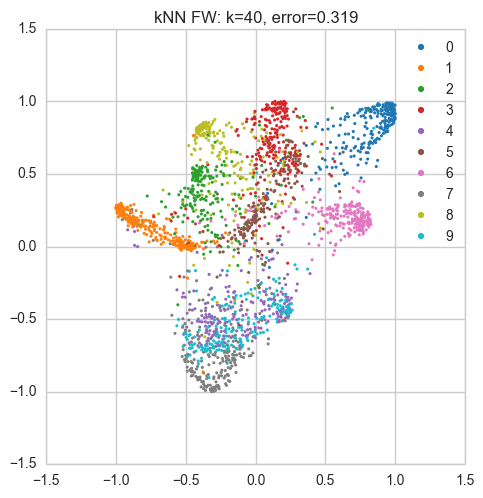

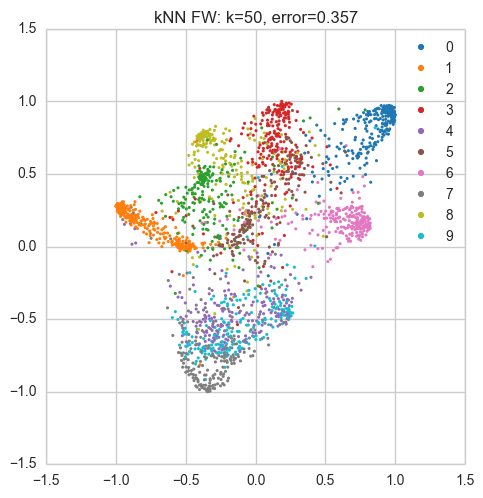

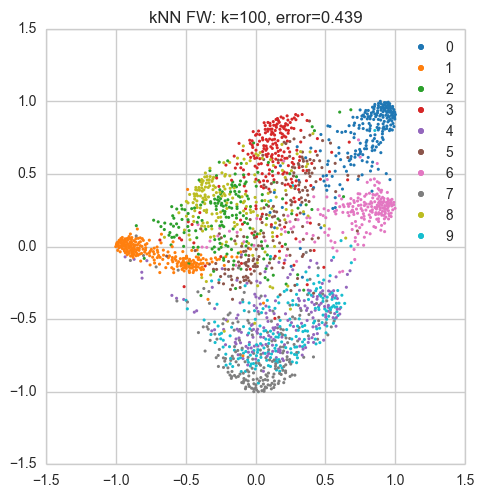

In [28]:
for k in [1, 5, 10, 20, 30, 40, 50, 100]:
    G = create_knn_graph(X_pca[:, :50], k=k)
    X_knn_fw, G_cy = network_layout(G)
    error = NN_generalization_error(X_knn_fw, labels)
    ax = plot_embed(X_knn_fw, labels)
    ax.set_title('kNN FW: k=%d, error=%.3f' % (k, error))


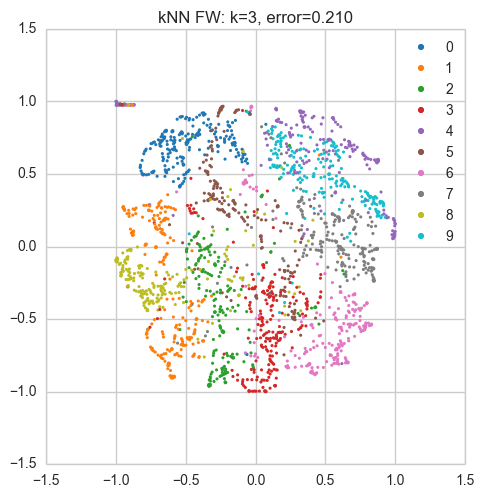

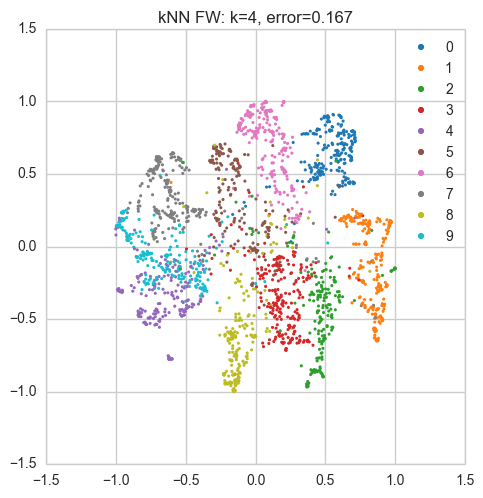

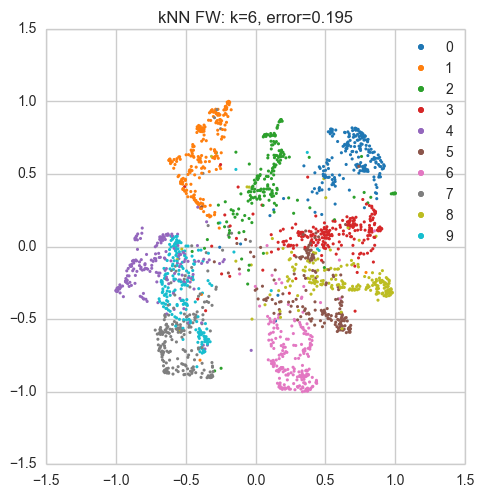

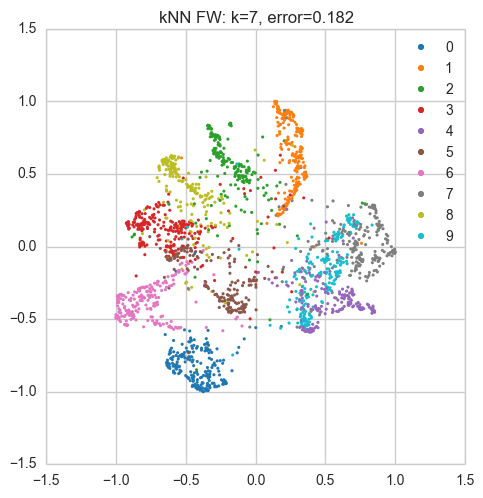

In [30]:
for k in [3, 4, 6, 7]:
    G = create_knn_graph(X_pca[:, :50], k=k)
    X_knn_fw, G_cy = network_layout(G)
    error = NN_generalization_error(X_knn_fw, labels)
    ax = plot_embed(X_knn_fw, labels)
    ax.set_title('kNN FW: k=%d, error=%.3f' % (k, error))


#### Perform thresholding to form graphs for the Firework layout

In [68]:
# thresholding-Firework
def create_graph_by_threshold(adj_mat, percentile):
    triu_idx = np.tril_indices(adj_mat.shape[0], 1)
    thresold = np.percentile(adj_mat[triu_idx], percentile)
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<thresold] = 0
    G = nx.from_numpy_matrix(adj_mat_)
    return G

def create_graph_by_threshold_knn(adj_mat, percentile, k=1, X=None):
    '''combine the graph from `create_graph_by_threshold` with a kNN graph.
    '''
    G_thres = create_graph_by_threshold(adj_mat, percentile)
    G_knn = create_knn_graph(X, k=k)
    return nx.compose(G_thres, G_knn)

In [69]:
adj_mat = compute_adjcency_mat(X_pca[:, :50], metric='euclidean')
print adj_mat.shape
adj_mat[:5, :5]

(2000, 2000)


array([[ 0.        ,  0.25492573,  0.30382282,  0.32471544,  0.31103414],
       [ 0.25492573,  0.        ,  0.47677177,  0.29810971,  0.39349115],
       [ 0.30382282,  0.47677177,  0.        ,  0.37594771,  0.34520698],
       [ 0.32471544,  0.29810971,  0.37594771,  0.        ,  0.42907238],
       [ 0.31103414,  0.39349115,  0.34520698,  0.42907238,  0.        ]], dtype=float32)

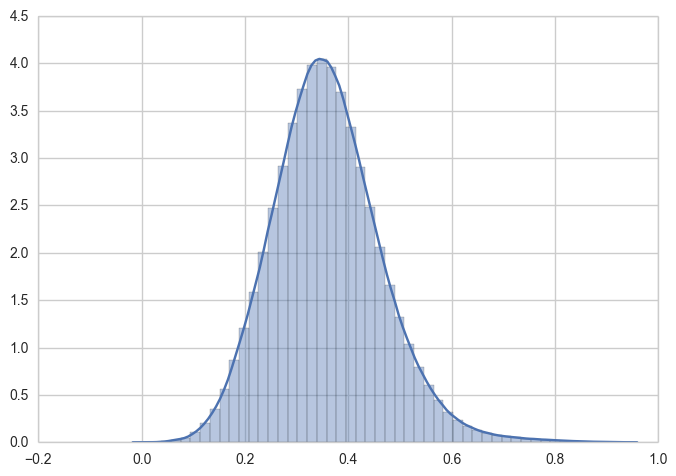

In [70]:
# Histogram for values in adj_mat
triu_idx = np.triu_indices(adj_mat.shape[0], 1)
sns.distplot(adj_mat[triu_idx])

2000 10011


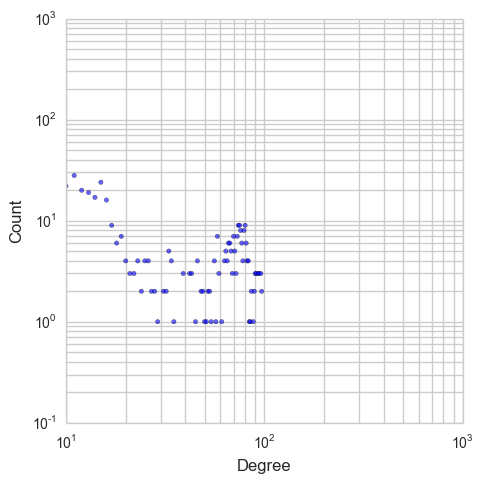

In [90]:
percentile = 99.5 
# percentile = 90
G = create_graph_by_threshold(adj_mat, percentile)
print G.number_of_nodes(), G.number_of_edges()
plot_degree_distribution(G)

/Library/Python/2.7/site-packages/sklearn/neighbors/graph.py:37: DeprecationWarning: The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.
  "behavior, set include_self=True.", DeprecationWarning)


14091 2000


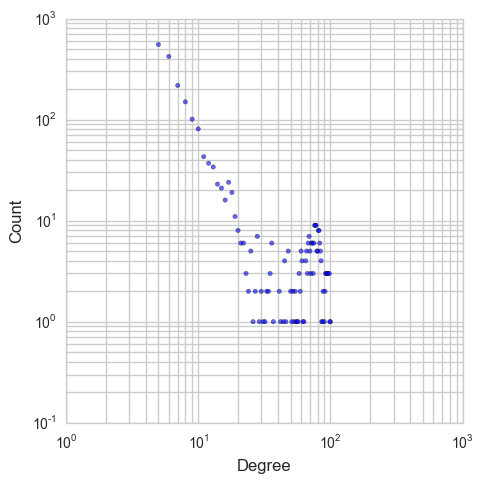

In [106]:
k = 4
G_thres_knn = create_graph_by_threshold_knn(adj_mat, percentile, k=k, X=X_pca[:, :50])
print G_thres_knn.number_of_edges(), G_thres_knn.number_of_nodes()
plot_degree_distribution(G_thres_knn)

In [107]:
X_thre_fw, G_cy = network_layout(G)
X_threknn_fw, G_cy = network_layout(G_thres_knn)

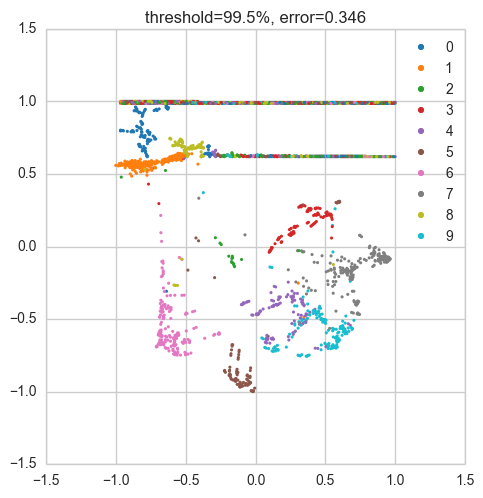

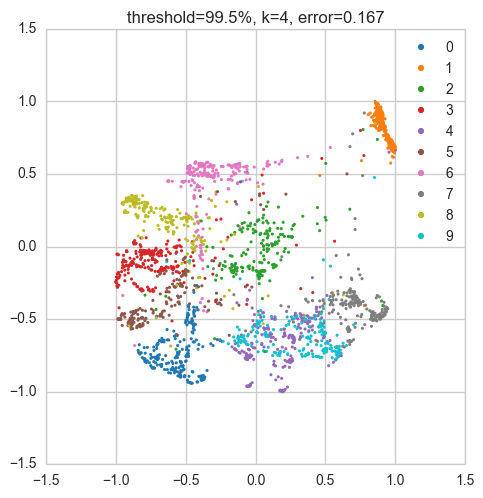

In [108]:
ax = plot_embed(X_thre_fw, labels)
error = NN_generalization_error(X_thre_fw, labels)
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_threknn_fw, labels)
error = NN_generalization_error(X_threknn_fw, labels)
ax.set_title('threshold=%.1f%%, k=%d, error=%.3f' %(percentile, k, error))

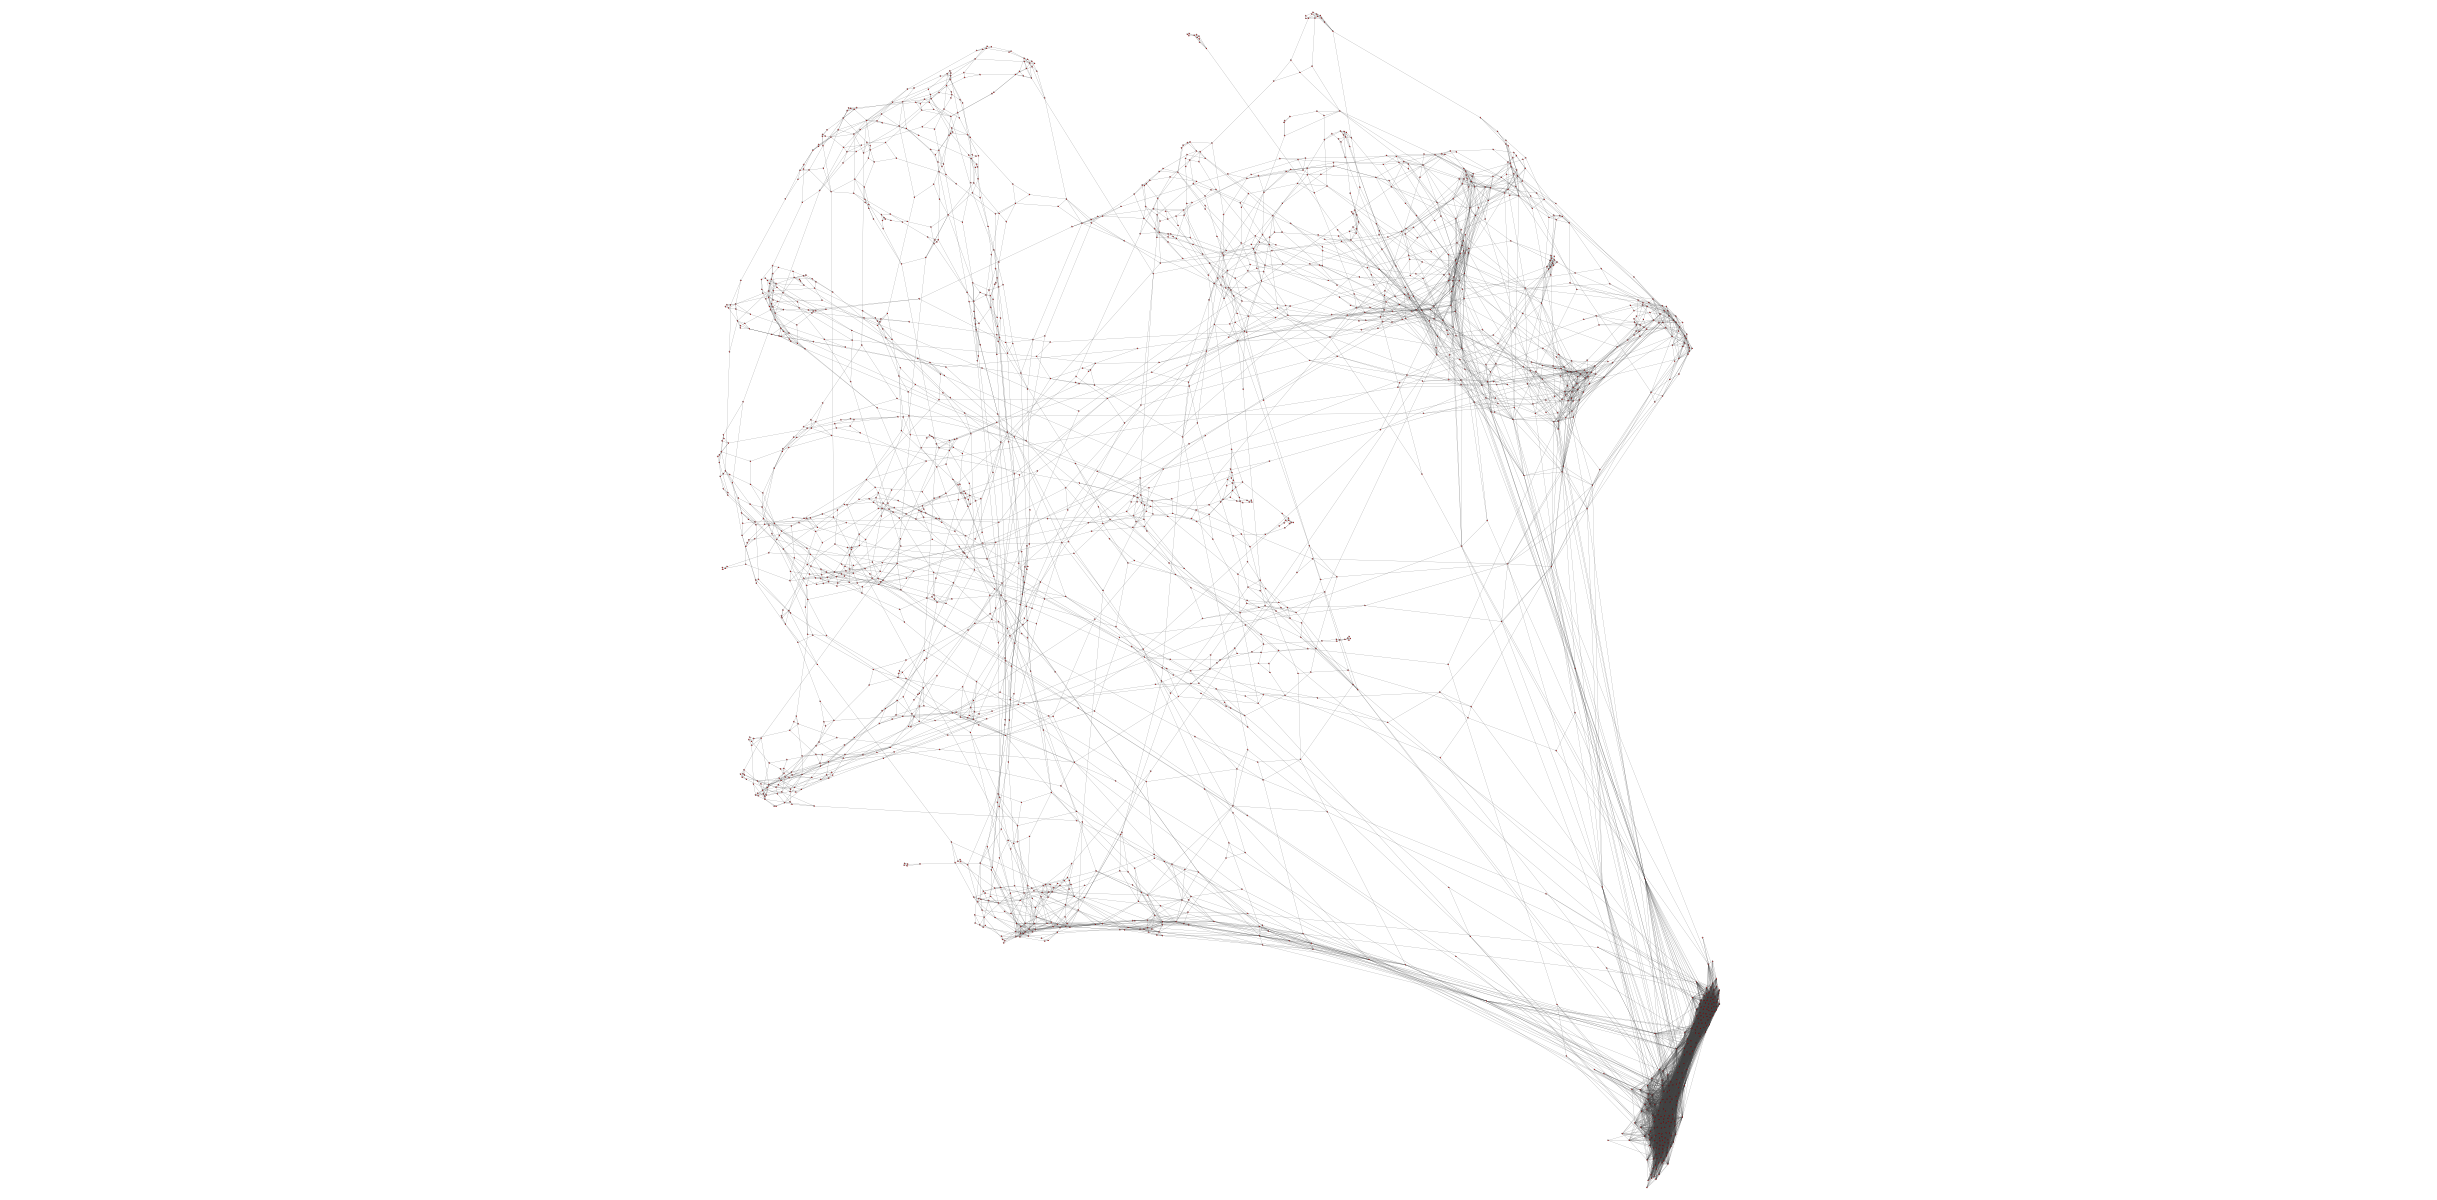

In [109]:
display.Image(G_cy.get_png())

#### Problem: there are some small connected components and even isolated nodes, how to deal with them?

Current ~~solution~~: exclude

In [110]:
G_new = nx.Graph()
G_new_tknn = nx.Graph()
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        G_new = nx.compose(G_new, cc)
print G_new.number_of_nodes(), G_new.number_of_edges()

for cc in nx.connected_component_subgraphs(G_thres_knn):
    if cc.number_of_nodes() > 10:
        G_new_Gknn = nx.compose(G_new_Gknn, cc)
print G_new_Gknn.number_of_nodes(), G_new_Gknn.number_of_edges()

1193 9849
2000 14091


To make a fair comparison between thresholding-Firework and t-SNE, re-compute the error by ignoring nodes in the small connected components.

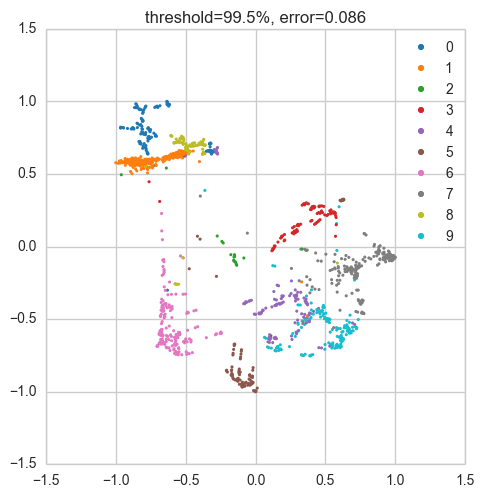

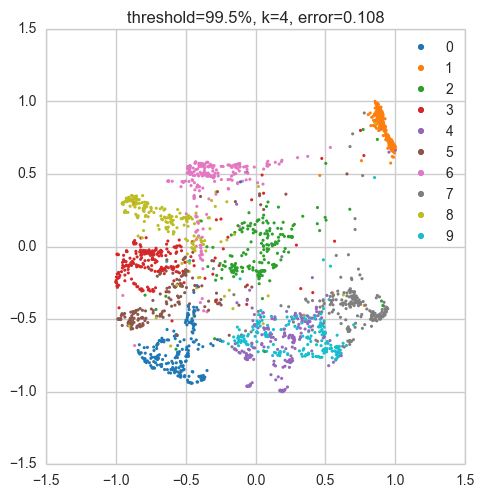

In [112]:
# Re-compute the error by ignoring the small CCs
node_idx_in_graph = G_new.nodes()
# node_idx_in_graph = G_new_Gknn.nodes()
sample_mask = np.in1d(np.arange(N), node_idx_in_graph)

ax = plot_embed(X_thre_fw[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_thre_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_threknn_fw, labels)
error = NN_generalization_error(X_threknn_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, k=%d, error=%.3f' %(percentile, k, error))

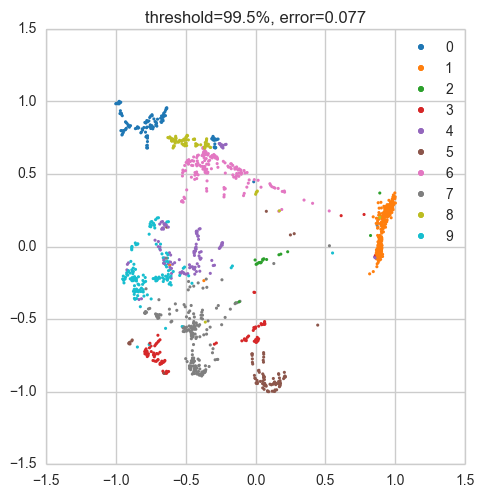

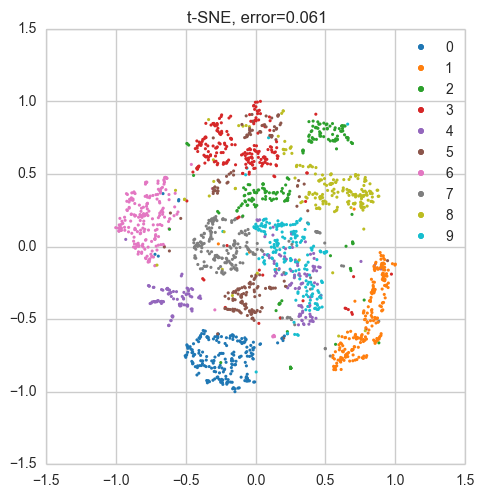

In [66]:
# Re-compute the error by ignoring the small CCs
node_idx_in_graph = G_new.nodes()
sample_mask = np.in1d(np.arange(N), node_idx_in_graph)

ax = plot_embed(X_thre_fw[sample_mask], labels[sample_mask])
error = NN_generalization_error(X_thre_fw[sample_mask], labels[sample_mask])
ax.set_title('threshold=%.1f%%, error=%.3f' %(percentile, error))

ax = plot_embed(X_tsne, labels)
error = NN_generalization_error(X_tsne[sample_mask], labels[sample_mask])
ax.set_title('t-SNE, error=%.3f' %error)

<a id="refs"></a>

## References

+ [Making sense of principal component analysis, eigenvectors & eigenvalues](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)
+ [MNIST For ML Beginners](https://www.tensorflow.org/get_started/mnist/beginners)
+ [Visualizing MNIST: An Exploration of Dimensionality Reduction](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)
+ [Tensorflow Embedding Projector](http://projector.tensorflow.org/)
+ [van der Maaten's t-SNE page](http://lvdmaaten.github.io/tsne/)
+ [van der Maaten et al.: Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf)
+ [van der Maaten: Learning a Parametric Embedding by Preserving Local Structure](http://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf)
+ [Kokiopoulou and Saad: Enhanced graph-based dimensionality reduction with repulsion Laplaceans](http://www.sciencedirect.com/science/article/pii/S0031320309001460)